### **Comparison of GAN with miniBatch GAN**
#### Deep Learning course - IASBS

In this exercise, a GAN and a MiniBatch GAN are implemented in Keras for MNIST and CFar10 image datasets.

This comparison code has been developed with help of multipule good references and webpages including:

- Goodfellow, et al., “Generative Adversarial Networks.”
- [David Gündisch's blog post](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)
- Tim Salimans, Ian Goodfellow, Wojciech Zaremba, Vicki Cheung, Alec Radford, Xi Chen (2016) Improved Techniques for Training GANs
- [Machine Learning Mastery post](https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/)
- [GAN — Ways to improve GAN performance by Jonathan Hui](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)


Importing dependencies


In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Minibatch Discrimination Layer

In [ ]:
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

# From a PR that is not pulled into Keras
# https://github.com/fchollet/keras/pull/3677
# I updated the code to work on Keras 2.x

class MinibatchDiscrimination(Layer):
    """Concatenates to each sample information about how different the input
    features for that sample are from features of other samples in the same
    minibatch, as described in Salimans et. al. (2016). Useful for preventing
    GANs from collapsing to a single output. When using this layer, generated
    samples and reference samples should be in separate batches.
    # Example
    ```python
        # apply a convolution 1d of length 3 to a sequence with 10 timesteps,
        # with 64 output filters
        model = Sequential()
        model.add(Convolution1D(64, 3, border_mode='same', input_shape=(10, 32)))
        # now model.output_shape == (None, 10, 64)
        # flatten the output so it can be fed into a minibatch discrimination layer
        model.add(Flatten())
        # now model.output_shape == (None, 640)
        # add the minibatch discrimination layer
        model.add(MinibatchDiscrimination(5, 3))
        # now model.output_shape = (None, 645)
    ```
    # Arguments
        nb_kernels: Number of discrimination kernels to use
            (dimensionality concatenated to output).
        kernel_dim: The dimensionality of the space where closeness of samples
            is calculated.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        weights: list of numpy arrays to set as initial weights.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        input_dim: Number of channels/dimensions in the input.
            Either this argument or the keyword argument `input_shape`must be
            provided when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(samples, input_dim + nb_kernels)`.
    # References
        - [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
    """

    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        # Set built to true.
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# initializing GAN class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)      
        # build Discriminator  
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])        
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        
        # build Generator
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)

        # Connection between Gnerator and Discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # Defining Discriminator's model
    def build_discriminator(self):
        model = Sequential()
	    	# model.add(Conv2D(16, (3,3), padding="valid", kernel_initializer=init, kernel_regularizer=reg, input_shape=(28, 28)))
        model.add(Conv2D(64, (3,3), border_mode='same', input_shape=self.img_shape))
        # model.add(Flatten(input_shape=self.img_shape))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(MinibatchDiscrimination(5, 3))
        model.add(Dense(256))
        out = model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)


    #Defining Generator Model
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    # Training process
    def train(self, epochs, batch_size=128, sample_interval=50):

        (X_train, _), (_, _) = mnist.load_data()        

        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):

                # select a bunch of real images   
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]    
                
                ## train discriminator
                # generating fake images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))    
                gen_imgs = self.generator.predict(noise)    

                # computing loss value
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)      #on real images
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)   #on fake images
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)                   # computing final loss

                # train Generator
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.combined.train_on_batch(noise, valid)

                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                # if epoch % sample_interval == 0:
                        # self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                cnt += 1
        # fig.savefig("images/%d.png" % epoch)
        axis('off')
        plt.close()



In [ ]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=132, sample_interval=10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(28, 28, 1..., padding="same")`


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               25690624  
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
minibatch_discrimination_1 ( (None, 517)               7680      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               132608    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 2.222093, acc.: 50.00%] [G loss: 1.029573]
1 [D loss: 0.203872, acc.: 98.11%] [G loss: 3.327266]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
5001 [D loss: 0.122747, acc.: 95.83%] [G loss: 8.530661]
5002 [D loss: 0.268701, acc.: 87.88%] [G loss: 5.184323]
5003 [D loss: 0.195458, acc.: 91.67%] [G loss: 7.597651]
5004 [D loss: 0.164350, acc.: 92.42%] [G loss: 6.368186]
5005 [D loss: 0.077127, acc.: 96.97%] [G loss: 7.331375]
5006 [D loss: 0.065263, acc.: 98.11%] [G loss: 5.284597]
5007 [D loss: 0.060226, acc.: 98.11%] [G loss: 7.530849]
5008 [D loss: 0.121574, acc.: 95.45%] [G loss: 7.107650]
5009 [D loss: 0.106562, acc.: 95.83%] [G loss: 7.370704]
5010 [D loss: 0.124415, acc.: 95.45%] [G loss: 6.956356]
5011 [D loss: 0.094783, acc.: 96.21%] [G loss: 6.600743]
5012 [D loss: 0.253573, acc.: 90.15%] [G loss: 6.992046]
5013 [D loss: 0.038155, acc.: 99.62%] [G loss: 8.333981]
5014 [D loss: 0.088191, acc.: 96.59%] [G loss: 6.648420]
5015 [D loss: 0.141223, acc.: 95.45%] [G loss: 7.020643]
5016 [D loss: 0.171470, acc.: 93.56%] [G loss: 6.919190]
5017 [D loss: 0.121607, acc.: 94.70%]

NameError: ignored

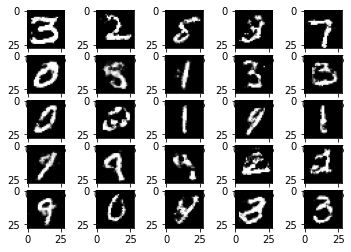

In [ ]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        cnt += 1
# fig.savefig("images/%d.png" % epoch)
axis('off')
plt.close()